In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/Shared drives/

/content/gdrive/Shared drives


In [0]:
cd /content/gdrive/Shared drives/DL_Final_Project

/content/gdrive/Shared drives/DL_Final_Project


In [0]:
pip install alphabet

  Created wheel for alphabet: filename=alphabet-0.0.7-cp36-none-any.whl size=5152 sha256=4d34d44c2e1670bc52a5b3f64a28d1f202f50d7efb8e946c8923e74104082a3c
  Stored in directory: /root/.cache/pip/wheels/74/e5/3f/ec098bbe7085fd90ef9de728a3df1a5cc23dc0459b76f17067
  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15777 sha256=5c2befa03a611bc7fea90aa8cc8e2566e235edca2310347bd4b9fe2af7c9ea0f
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
  Created wheel for filemagic: filename=filemagic-1.6-cp36-none-any.whl size=9545 sha256=efcf6dad5518eb8ba7a072f1d3e550615c9da3cccbc4f4dcc487f529af52adfe
  Stored in directory: /root/.cache/pip/wheels/2e/0e/8e/c4625de9d6f723017996dd718d5fabe1c7bb1fbce7389d3bf6
Successfully built alphabet googletrans filemagic


In [0]:
import numpy as np
import pandas as pd
import glob,os
from PIL import Image
from torchvision import datasets, transforms
import torch
from torchvision import transforms
import torch.utils.data as Data
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from alphabet import alphabet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear(576, 1024),
            nn.Dropout(0.5),  # drop 50% of the neuron
            nn.ReLU())
        self.rfc = nn.Sequential(
            # nn.Linear(1024, 4*10),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.rfc(out)
        #out = nn.functional.softmax(out)
        return out

In [0]:
img_names = os.listdir('./captcha/e3-processed/data/')
X = []
Y = []
print("Image numbers:", len(img_names))
for num, img_path in enumerate(img_names):
    if num%100==0:
        print("image", num)
    img = np.array(Image.open('./captcha/e3-processed/data/'+img_path))
    left = img.shape[1]
    right = 0
    for j in range(0, img.shape[0], 10):
        for i in range(img.shape[1]):
            if img[j][i].sum() > 300:
                if i < left:
                    left = i
                break
        for i in range(img.shape[1]-1, 0, -1):
            if img[j][i].sum() > 300:
                if i > right:
                    right = i
                break

    top = img.shape[0]
    bottom = 0
    for j in range(0, img.shape[1], 10):
        for i in range(img.shape[0]):
            if img[i][j].sum() > 300:
                if i < top:
                    top = i
                break
        for i in range(img.shape[0]-1, 0, -1):
            if img[i][j].sum() > 300:
                if i > bottom:
                    bottom = i
                break
    # print(left, right)
    dis = (right - left) // 4
    X.append(img[top:bottom,left:left+dis])
    X.append(img[top:bottom,left+dis:left+dis*2])
    X.append(img[top:bottom,left+dis*2:left+dis*3])
    X.append(img[top:bottom,left+dis*3:right])
    Y.append(int(img_path[0]))
    Y.append(int(img_path[1]))
    Y.append(int(img_path[2]))
    Y.append(int(img_path[3]))

9


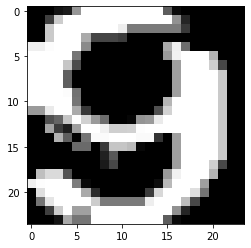

In [0]:
index = 10000
plt.imshow(X[index].transpose((1, 2, 0)))
print(Y[index])

In [0]:
import cv2
for i in range(len(X)):
    X[i] = cv2.resize(X[i], (24, 24)).transpose((2, 0, 1))

In [0]:
testing_split = .2
test_split = int(np.floor(testing_split * len(X)))

testing_data_x = torch.Tensor(X[:test_split])
testing_data_y = torch.Tensor(Y[:test_split])
training_data_x = torch.Tensor(X[test_split:])
training_data_y = torch.Tensor(Y[test_split:])

training_dataset = Data.TensorDataset(training_data_x, training_data_y)
testing_dataset = Data.TensorDataset(testing_data_x, testing_data_y)
validation_split = .2

dataset_size = len(training_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


In [0]:
# 超参数
EPOCH = 10
BATCH_SIZE = 100

#transform = transforms.Compose([transforms.Resize((64, 64)), 
                                #transforms.ToTensor(),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalization 
#                               ])
# transform = transforms.ToTensor()
# transform = transforms.Compose([transforms.Resize((215, 80)), transforms.ToTensor(),])
#data_loc
"""train_dataset = CaptchaData('./captcha/e3-processed/data/', transform)
test_split = .2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, 
                        drop_last=True, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=0, 
                        drop_last=True, sampler=test_sampler)"""
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=BATCH_SIZE, num_workers=0, 
                        drop_last=True, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=BATCH_SIZE, num_workers=0, 
                        drop_last=True, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset=testing_dataset, batch_size=BATCH_SIZE, num_workers=0, 
                        drop_last=True, shuffle=False)

print('done')


done


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


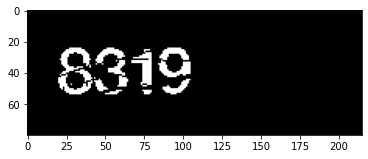

In [0]:
plt.imshow(train_dataset[8][0].cpu().numpy().transpose((1,2,0)))
img = train_dataset[8][0].cpu().numpy().transpose((1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


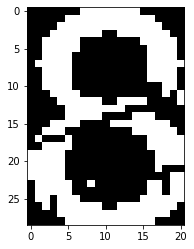

In [0]:
left = img.shape[1]
right = 0
for j in range(30, 50):
    for i in range(img.shape[1]):
        if img[j][i].sum() > 300:
            if i < left:
                left = i
            break
    for i in range(img.shape[1]-1, 0, -1):
        if img[j][i].sum() > 300:
            if i > right:
                right = i
            break

top = img.shape[0]
bottom = 0
for j in range(0, img.shape[1], 10):
    for i in range(img.shape[0]):
        if img[i][j].sum() > 300:
            if i < top:
                top = i
            break
    for i in range(img.shape[0]-1, 0, -1):
        if img[i][j].sum() > 300:
            if i > bottom:
                bottom = i
            break
# print(left, right)
dis = (right - left) // 4
plt.imshow(img[top:bottom,left:left+dis,:])

In [0]:
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)

cnn = CNN()
cnn = cnn.to(device)
torch.set_default_tensor_type(torch.cuda.FloatTensor)
cnn.train()
print('init net')
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

init net


In [0]:
print(cnn)

In [0]:
history_loss = []
history_train_acc = []
history_valid_acc = []
EPOCH = 5000
for epoch in range(EPOCH):
    print('Epoch:', epoch)
    train_loss = 0
    train_correct = 0
    train_total = 0
    for step, (b_x, b_y) in enumerate(train_loader):   # 分配 batch data, normalize x when iterate train_loader
        #print(step)
        b_x, b_y = b_x.cuda(), b_y.cuda()
        output = cnn(b_x)               # cnn output
        loss = criterion(output, b_y.long())   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()     
           # apply gradients
        train_loss += loss.item()
        # predicted = output
        _, predicted = output.max(1)
        train_total += b_y.size(0)
        # train_correct += calculat_acc(predicted,b_y)
        train_correct += predicted.eq(b_y).sum().item()
    history_loss.append(train_loss/len(train_loader))
    history_train_acc.append(train_correct/train_total)
    print('【Training】Loss: %.6f | Acc: %.3f%% (%d/%d)' % ( train_loss/len(train_loader.dataset), 100.*(train_correct/train_total), train_correct, train_total ))

    with torch.no_grad():
        valid_loss = 0
        valid_correct = 0
        valid_total = 0
        for step, (b_x, b_y) in enumerate(valid_loader):   # 分配 batch data, normalize x when iterate train_loader
            b_x, b_y = b_x.cuda(), b_y.cuda()
            output = cnn(b_x)               # cnn output
            
            loss = criterion(output, b_y.long())   # cross entropy loss
            optimizer.zero_grad()           # clear gradients for this training step

            valid_loss += loss.item()
            _, predicted = output.max(1)
            valid_total += b_y.size(0)
            # test_correct += calculat_acc(predicted,b_y)
            valid_correct += predicted.eq(b_y).sum().item()
    history_valid_acc.append((valid_correct/valid_total))
    print('【validation】Loss: %.6f | Acc: %.3f%% (%d/%d)' % ( valid_loss/len(valid_loader), 100.*(valid_correct/valid_total), valid_correct, valid_total ))


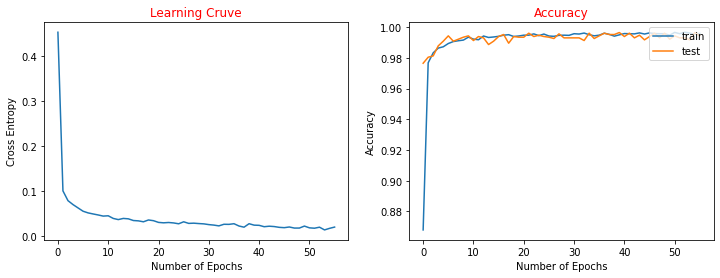

In [0]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
ax[0].set_title('Learning Cruve', color='r')
ax[0].set_xlabel('Number of Epochs')
ax[0].set_ylabel('Cross Entropy')
ax[0].plot(history_loss)

ax[1].set_title('Accuracy', color='r')
ax[1].set_xlabel('Number of Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].plot(history_train_acc, label = 'train')
ax[1].plot(history_valid_acc, label = 'valid')
plt.legend(loc=1)

In [0]:
def calculat_acc(output, target):
    """ output, target = output.view(-1, 10), target.view(-1, 10)
    output = nn.functional.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    target = torch.argmax(target, dim=1)"""
    output, target = output.view(-1, 4), target.view(-1, 4)
    correct_list = []
    for i, j in zip(target, output):
        if torch.equal(i.float(), j.float()):
            correct_list.append(1)
        else:
            correct_list.append(0)
    acc = sum(correct_list)
    return acc
test_loss = 0
test_correct = 0
test_total = 0

for step, (b_x, b_y) in enumerate(test_loader):   # 分配 batch data, normalize x when iterate train_loader
    b_x, b_y = b_x.cuda(), b_y.cuda()
    output = cnn(b_x)               # cnn output
    
    loss = criterion(output, b_y.long())   # cross entropy loss
    optimizer.zero_grad()           # clear gradients for this training step

    test_loss += loss.item()
    _, predicted = output.max(1)
    test_total += b_y.size(0)
    test_correct += calculat_acc(predicted,b_y)
    # test_correct += predicted.eq(b_y).sum().item()
history_test_acc.append((test_correct/test_total))
print('【Testing】Loss: %.4f | Acc: %.2f%% (%d/%d)' % ( test_loss/len(test_loader), (test_correct/((len(test_loader))/4)), test_correct, test_total/4 ))


【Testing】Loss: 0.0105 | Acc: 98.96% (569/575)


In [0]:
len(test_loader.dataset)

2353

In [0]:
correct_list = []
for i, j in zip(b_y.view(-1, 4), predicted.view(-1, 4)):
    print("target:",i.float(),"predict:",j.float())
    if torch.equal(i.float(), j.float()):
        correct_list.append(1)
    else:
        correct_list.append(0)
acc = sum(correct_list) / len(correct_list)
print(acc)

target: tensor([8., 3., 5., 2.]) predict: tensor([8., 3., 5., 2.])
target: tensor([8., 3., 4., 7.]) predict: tensor([8., 3., 4., 7.])
target: tensor([8., 7., 2., 6.]) predict: tensor([8., 7., 2., 6.])
target: tensor([1., 7., 1., 3.]) predict: tensor([1., 7., 1., 3.])
target: tensor([4., 2., 1., 8.]) predict: tensor([4., 2., 1., 8.])
target: tensor([3., 7., 6., 7.]) predict: tensor([3., 7., 6., 7.])
target: tensor([0., 9., 7., 0.]) predict: tensor([0., 9., 7., 0.])
target: tensor([4., 4., 0., 0.]) predict: tensor([4., 4., 0., 0.])
target: tensor([8., 1., 4., 7.]) predict: tensor([8., 1., 4., 7.])
target: tensor([7., 0., 0., 5.]) predict: tensor([7., 0., 0., 5.])
target: tensor([6., 2., 6., 5.]) predict: tensor([6., 2., 6., 5.])
target: tensor([4., 5., 9., 3.]) predict: tensor([4., 5., 9., 3.])
target: tensor([6., 5., 2., 6.]) predict: tensor([6., 5., 2., 6.])
target: tensor([5., 7., 7., 8.]) predict: tensor([5., 7., 7., 8.])
target: tensor([0., 8., 9., 3.]) predict: tensor([0., 8., 9., 